# Sageでグラフを再現してみよう：データ解析のための統計モデリング入門第９章
この企画は、雑誌や教科書にでているグラフをSageで再現し、 グラフの意味を理解すると共にSageの使い方をマスターすることを目的としています。

前回に続き、
[データ解析のための統計モデリング入門](http://www.amazon.co.jp/dp/400006973X/)
（以下、久保本と書きます）の第9章の例題をSageを使って再現してみます。

今回の目標は、図9.6です。

![図９．６](images/Fig9.6.png)

数式処理システムSageのノートブックは、計算結果を表示するだけではなく、実際に動かすことができるの大きな特徴です。
この機会にSageを分析に活用してみてはいかがでしょう。
        
## 前準備       
今回使用するpyjagsがSageの環境では動作しないため、kernelはPython 2を使用します。

最初に必要なライブラリーやパッケージをロードしておきます。sage_util.py, RUtil.pyはloadの代わりにexecを使用して読み込みます。

In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/sage_table_form.css">

In [68]:
# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# statsmodelsを使ってglmを計算します
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
# jags用パッケージ
import pyjags
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
exec(open('script/sage_util.py').read())
# Rユーティリティ
exec(open('script/RUtil.py').read())
# 乱数のシードをセット
np.random.seed(101)

## 例題のデータ
今回の例題は、サポートページにR形式のd.RDataで提供されているため、RからJSON形式に変換してpythonで使用しています。

In [3]:
# 9章のデータをRからJSON形式に変換
d = pd.read_json('''
[{"x":3,"y":5},{"x":3.2105,"y":3},{"x":3.4211,"y":6},{"x":3.6316,"y":7},{"x":3.8421,"y":7},
    {"x":4.0526,"y":5},{"x":4.2632,"y":9},{"x":4.4737,"y":9},{"x":4.6842,"y":7},{"x":4.8947,"y":10},
    {"x":5.1053,"y":12},{"x":5.3158,"y":8},{"x":5.5263,"y":7},{"x":5.7368,"y":4},{"x":5.9474,"y":4},
    {"x":6.1579,"y":11},{"x":6.3684,"y":9},{"x":6.5789,"y":9},{"x":6.7895,"y":8},{"x":7,"y":6}]
''')

### データ処理のルーティーン
データを読み込んだら、以下のルーティーンを実行します。
- describeでデータの統計情報を把握する
- 可視化してデータの特徴をつかむ

今回のデータは、3章のデータと同様で、架空の植物$i$の種子数を$y_i$とサイズ$x_i$からなる20個のデータです。

In [86]:
d.describe()

,x,y,yhat
count,20.000000,20.000000,20.000000
mean,5.000000,7.300000,7.300000
std,1.245486,2.408319,0.756972
min,3.000000,3.000000,6.147684
25%,3.999975,5.750000,6.682186
50%,5.000000,7.000000,7.263051
75%,6.000025,9.000000,7.894257
max,7.000000,12.000000,8.580117


プロット図からx, yともに整数の離散値であり、xとyの関係は以下の様になっています。線形回帰の結果も合わせて表示しています。

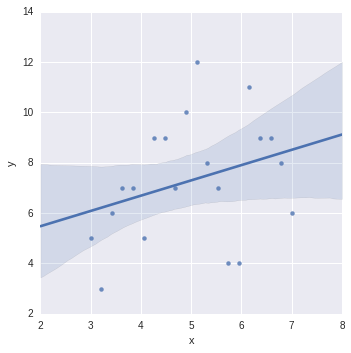

In [5]:
# seabornの線形回帰機能を使って、入力データのプロット（lmplot）
sns.lmplot(x='x', y='y', data=d)
plt.show()

２．６節の「確率分布の選び方」から、離散値のyの平均と分散を求めてみます。この結果、平均と分散がほぼ等しいので、ポアソン分布を仮定します。

In [88]:
# yの値は0以上の離散値で、yの平均と分散がほぼ等しい
print d.y.mean(), d.y.var()

7.3 5.8


平均λ=7.3のポアソン分布の確率密度のプロットとyの確率密度のプロットを重ね合わせてみます。確率密だがほぼ一致することが分かります。

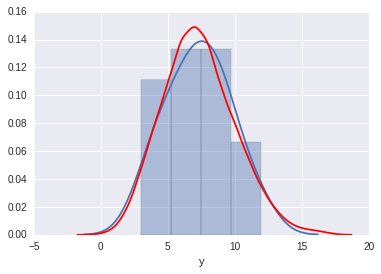

In [83]:
# d.yの確率密度分布（青）と平均7.3のポアソン分布（赤）を重ねてみる
ax = sns.distplot(d.y)
# 平均λ= 7.3のポアソン分布からサンプルを3000個生成して、その確率密度分布をプロット
sns.distplot(np.random.poisson(lam=7.3, size=3000), hist=False, color='red', ax=ax)
plt.show()

## GLMでポアソン分布のパラメータ推定
3章と同様に、GLMを使ってポアソン分布のパラメータを求めてみます。

In [49]:
# statsmodelsを使ってglmを計算します
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr

以下の解析から、ポアソン分布の平均$\lambda=exp(1.57 + 0.08x)$が得られます。

In [52]:
fit = smf.glm('y ~ x', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
fit.params

Intercept    1.566046
x            0.083343
dtype: float64

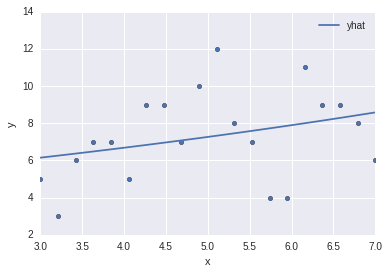

In [46]:
# λの予測値nuをyhatにセット
d['yhat'] = fit.predict()
ax = d.plot(x='x', y='yhat')
d.plot(kind='scatter', x='x', y='y', ax=ax)
plt.show()

## GLMのベイズモデル化
ベイズモデルの事後分布は、（尤度）ｘ（事前分布）に比例することから、以下の関係が成り立ちます。
$$
p(\beta_1, \beta_2 | Y) \propto p(Y | \beta_1, \beta_2)\, p(\beta_1)\, p(\beta_2)
$$

ここで、$p(\beta_1, \beta_2 | Y)$は、Yが与えられたときの$\{ \beta_1, \beta_2 \}$の同時分布です。

### 無情報事前分布
$p(\beta_1), p(\beta_2)$は、$\beta_1, \beta_2$の事前分布ですが、どのような分布をとるかが指定されていない、部情報事前分布と呼ばれるものです。ここではできるだけ均質な分布とするために、N(0, 100)のひらべったい正規分布とします。

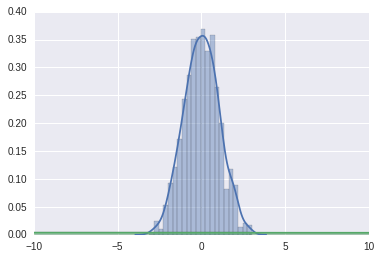

In [42]:
# 平均０、標準偏差1　N(0, 1)と平均０、標準偏差100　N(0, 100)のヒストグラムを比較
np.random.seed(101)
N_1 = [np.random.normal(0, 1) for i in range(1000)]
N_100 = [np.random.normal(0, 100)  for i in range(1000)]
ax = sns.distplot(N_1)
sns.distplot(N_100, ax=ax).set(xlim=(-10, 10))
plt.show()

## jagsを使ったベイズ統計モデルの事後分布の推定
久保本では、WinBUGSを使っていますが、MacOSXやLinuxではWinBUGSと定義ファイルが同じ、jagsを使用します。

以下に、平均λが$beta_1 + \beta_2 x$のポアソン分布を持つモデルを定義します。

model｛｝で囲まれている部分がモデル定義部で、この中にforループ、確率的な関係を表す~と左辺を右辺に代入する<-の演算子を使ってモデルを構築します。

本来なら、
<pre>
log(lambda[i]) <- beta1 + beta2 * X[i] 
</pre>
とするところを、
<pre>
log(lambda[i]) <- beta1 + beta2 * (X[i] - MeanX)
</pre>
としているのは、処理の高速化のためだそうです。実際オリジナルの式だと収束にとても時間がかかりました。

dpoisは、ポアソン分布を、dnormは正規分布を表し、dnormの第2引数にはtau=分散を指定します。従ってbeta1, beta2には、分散100の正規分布N(0, 100）からサンプリングされます。

In [91]:
N = len(d.x)
code = '''
model {
    for (i in 1:N) {
        Y[i] ~ dpois(lambda[i])
        log(lambda[i]) <- beta1 + beta2 * (X[i] - MeanX)
    }
    beta1 ~ dnorm(0, 1.0E-4)
    beta2 ~ dnorm(0, 1.0E-4)
}
'''

pyjags.Modelへの引数は、以下の通りです。
- code: モデルを指定
- data: モデルで使用されるデータを　dict形式で指定
- chains: 平行してサンプリングを行う個数を指定

In [92]:
model = pyjags.Model(code, data=dict(X=d.x, Y=d.y, N=N, MeanX= d.x.mean()), chains=3)

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00


model.sampleを使って、変数beta1, beta2についてサンプリングします。

In [93]:
samples = model.sample(500, vars=['beta1', 'beta2'])

sampling: iterations 1500 of 1500, elapsed 0:00:00, remaining 0:00:00


samplesに返された値はdict型で、'beta1', 'beta2'でそれぞれのサンプリングを取り出します。

個々のサンプルは、1xサンプリング数xchainsの配列となっています。

In [96]:
samples['beta1'].shape

(1, 500, 3)

In [97]:
def summary(samples, varname, p=95):
    values = samples[varname]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.2f}, {}% credible interval [{:>4.2f} {:>4.2f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in ['beta1', 'beta2']:
    summary(samples, varname)

beta1  mean =  1.98, 95% credible interval [1.84 2.11]
beta2  mean =  0.09, 95% credible interval [-0.03 0.19]


## 結果の可視化
R用のrjagsでは、サンプリングの精度を表す$\hat{R}$等が求められますが、pyjagsにはそれらの計算機能がありません。
その代わりサンプリング結果を可視化して判断することにします。

chainsのch1, ch2, ch3がほぼ同じような分布をしており、収束していると考えられます。

確率分布も1.98を中心としたきれいな分布になっています。

In [10]:
# beta1の可視化
df_b1 = pd.DataFrame(samples['beta1'][0], columns=['ch1', 'ch2', 'ch3'])

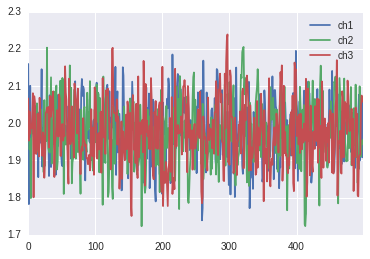

In [11]:
df_b1.plot()
plt.show()

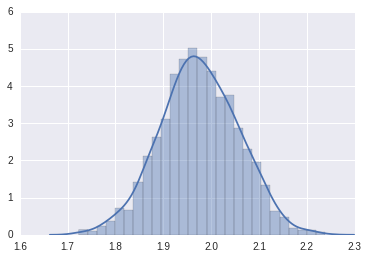

In [12]:
sns.distplot(df_b1.values.flatten())
plt.show()

同様にbeta2の結果もプロットしてみます。

In [13]:
# beta2の可視化
df_b2 = pd.DataFrame(samples['beta2'][0], columns=['ch1', 'ch2', 'ch3'])

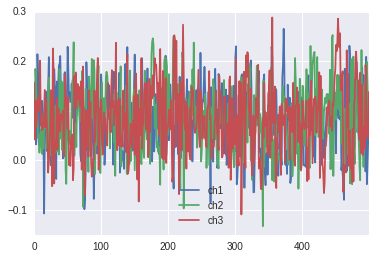

In [14]:
df_b2.plot()
plt.show()

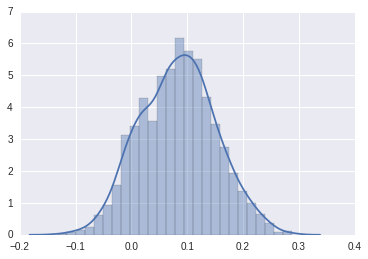

In [15]:
sns.distplot(df_b2.values.flatten())
plt.show()

## 図９．６のプロット
準備が整ったので、目標の図9.6をプロットしてみましょう。

各サンプリング値から平均λ（beta1, beta2から求まる）の曲線をプロットする関数add_meanを定義します。

次に、入力データをプロットし、サンプルのλの予測値から曲線をプロットし、最後にbeta1, beta2の中央値を
使った曲線をプロットします。

In [16]:
def add_mean(beta1, beta2, alpha, color):
    plt.plot(d.x, np.exp(beta1 + beta2*(d.x - d.x.mean())).values, c=color, alpha =alpha)

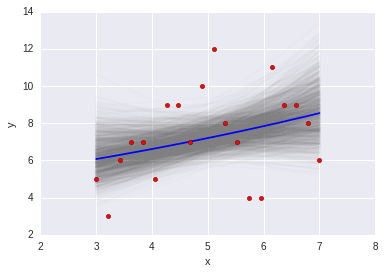

In [17]:
# 入力データのプロット
plt.scatter(d.x, d.y, c='red', zorder=3)
# サンプルのλの予測値をプロット
for (beta1, beta2) in zip(df_b1.values.flatten(), df_b2.values.flatten()):
    add_mean(beta1, beta2, 0.02, 'gray')
# 中央値を使ったプロット
beta1_median = np.median(df_b1.values.flatten())
beta2_median = np.median(df_b2.values.flatten())
add_mean(beta1_median, beta2_median, 1.0, 'blue')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

beta1とbeta2の関係もプロットしてみます。
この結果からbeta1とbeta2の間には相関がないことが分かります。

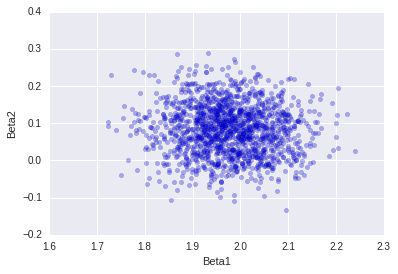

In [18]:
plt.scatter(df_b1.values.flatten(), df_b2.values.flatten(), alpha = 0.3)
plt.xlabel("Beta1")
plt.ylabel("Beta2")
plt.show()

### 共役な事前分布
パラメータの分布が予測できる場合には、その共役な事前分布を使ってギブスサンプリングします。

In [19]:
hdr = ["パラメータ", "共役な事前分布"]
tbl = [
    ["正規分布の平均", "正規分布"],
    ["正規分布の分散", "逆ガンマ分布"],
    ["多変量正規分布の分散共分散行列", "逆ウィシャート分布"],
    ["ガンマ分布のパラメータ", "ガンマ分布"],
    ["ポアソン分布の平均", "ガンマ分布"],
    ["二項分布の生起確率", "ベータ分布"],
    ["多項分布の生起確率", "ディリクレ分布"]
]
Table2Html(tbl, header=hdr)

パラメータ,共役な事前分布
正規分布の平均,正規分布
正規分布の分散,逆ガンマ分布
多変量正規分布の分散共分散行列,逆ウィシャート分布
ガンマ分布のパラメータ,ガンマ分布
ポアソン分布の平均,ガンマ分布
二項分布の生起確率,ベータ分布
多項分布の生起確率,ディリクレ分布
